In [1]:
# # Install requered libraries if needed
# !pip install toml --user
# !pip install segmentation-models --user
# !pip install gitpython --user

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# fix seed
sys.path.append('..')
import utils.seed

# fix seed one more time
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Using TensorFlow backend.


In [3]:
# external imports
import numpy as np
import json
import toml
import hashlib
import argparse
import pandas as pd
import shutil 
import keras
from keras.models import Model
from keras import layers
from keras.optimizers import Adam

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

from torch.utils.data import WeightedRandomSampler

In [4]:
from utils.datasets import ShipClsSegDataset, make_transform, to_dict
from utils.augmenters import get_augmenter
from utils.samplers import get_sampler
from utils.reproduce import save_commit_hash, save_config

In [5]:
# import importlib
# importlib.reload(keras_backend)

In [6]:
import keras_backend
from keras_backend.generators import cls_seg_generator
from keras_backend.callbacks import get_callbacks
from keras_backend.losses import get_losses_dict
from keras_backend.metrics import get_metrics_dict
from keras_backend.custom_models import DSUnet

In [7]:
# read pipeline configuration file
CONFIG_PATH = '../config_cls_seg.toml'
config = toml.load(CONFIG_PATH)

In [8]:
config

{'augmentation': {'Flip': {'p': 0.75},
  'RandomRotate90': {'p': 0.75},
  'ShiftScaleRotate': {'rotate_limit': 5.0,
   'scale_limit': 0.2,
   'shift_limit': 0.2},
  'Transpose': {'p': 0.5}},
 'callbacks': {'ModelCheckpoint': {'filepath': 'model-{val_seg_iou_score}.h5',
   'mode': 'max',
   'monitor': 'val_seg_iou_score',
   'save_best_only': True,
   'save_weights_only': True,
   'verbose': 1},
  'ReduceLROnPlateau': {'epsilon': 0.003,
   'factor': 0.3,
   'monitor': 'val_seg_iou_score',
   'patience': 10,
   'verbose': 1},
  'TensorBoard': {'write_graph': False}},
 'data': {'checkpoints_dir': '/home/user/project/checkpoints/',
  'folds_csv': '/home/user/project/data/dataset/folds_768.csv',
  'logs_dir': '/home/user/project/logs/',
  'masks_csv': '/home/user/project/data/dataset/train_ships_768.csv',
  'test': '/home/user/project/data/dataset/test',
  'train': '/home/user/project/data/dataset/train_768/'},
 'losses': {'cls': 'binary_crossentropy', 'seg': 'bce_jaccard_loss'},
 'metrics'

In [9]:
# define data transform parameters such as augmentation and preprocessing
augmenter = get_augmenter(config['augmentation'])
preprocessing_fn = get_preprocessing(config['model']['seg_params']['backbone_name'])

train_transform = make_transform(augmenter=augmenter, preprocessing_fn=preprocessing_fn)
valid_transform = make_transform(preprocessing_fn=preprocessing_fn)

In [10]:
# read train data and split for oout of fold validation
masks_df = pd.read_csv(config['data']['masks_csv'])
folds_df = pd.read_csv(config['data']['folds_csv'])

df = pd.merge(folds_df, masks_df, on='ImageId')

train_df = df[df['fold'] != config['training']['oof']].drop('fold', axis=1)
valid_df = df[df['fold'] == config['training']['oof']].drop('fold', axis=1)

# convert dataframes to dict for fast masks search
train_dict = to_dict(train_df)
valid_dict = to_dict(valid_df)

Indexing... ETA - 14.5857 sec.
Indexing... ETA - 3.6815 sec.


In [11]:
train_ids = list(train_dict.keys())
valid_ids = list(valid_dict.keys())

In [12]:
#prepare samplers (with different ratio)
# train sampler 
train_labels = np.array([1 if train_dict[id][0] else 0 for id in train_ids])
## calculate number of samples in whole traning process
train_n_samples = (config['training']['train_batch_size'] * config['training']['train_steps'] * 
                  (config['training']['epoch_end'] - config['training']['epoch_start'] + 2))
print(train_n_samples)

TrainSampler = get_sampler(config['sampling']['train']['strategy'])
train_sampler = TrainSampler(train_labels, config['sampling']['train']['params'], n_samples=train_n_samples)


#prepare samplers (with different ratio)

# # valid sampler
valid_labels = np.array([1 if valid_dict[id][0] else 0 for id in valid_ids])
## calculate number of samples in whole validation process
valid_n_samples = (config['training']['valid_batch_size'] * config['training']['valid_steps'] * 
                  (config['training']['epoch_end'] - config['training']['epoch_start'] + 2))
print(valid_n_samples)

ValidSampler = get_sampler(config['sampling']['valid']['strategy'])
valid_sampler = ValidSampler(valid_labels, config['sampling']['valid']['params'], n_samples=valid_n_samples)

416000
208000


In [13]:
# define datasets and data generators
train_dataset = ShipClsSegDataset(train_ids, config['data']['train'], 
                                        masks_df=train_dict, transform=train_transform)

valid_dataset = ShipClsSegDataset(valid_ids, config['data']['train'], 
                                        masks_df=valid_dict, transform=valid_transform)


train_gen = cls_seg_generator(dataset=train_dataset, 
                                   batch_size=config['training']['train_batch_size'],
                                   sampler=train_sampler,
                                   num_workers=16)

valid_gen = cls_seg_generator(dataset=valid_dataset, 
                                   batch_size=config['training']['valid_batch_size'],
                                   sampler=valid_sampler,
                                   num_workers=4)

In [14]:
# import matplotlib.pyplot as plt 

# ### check bathces
# def visualize(sample):
#     plt.figure()
#     plt.subplot(121)
#     plt.imshow(sample['image'].squeeze())
#     plt.title(sample['label'].squeeze())
    
#     plt.subplot(122)
#     plt.imshow(sample['mask'].squeeze())
#     plt.show()
    
    

# for batch in train_gen:
#     for i in range(len(batch[0])):
#         sample = {'image': batch[0][i], 
#                   'label': batch[1]['cls'][i],
#                   'mask': batch[1]['seg'][i],
#                  }
#         visualize(sample)
#     break

In [15]:
# i = 0
# buf = []
# for batch in train_gen:
#     print(batch[1].sum())
#     buf.append(batch[1].sum())
#     i+=1
#     if i > 500:
#         break

# print(np.mean(buf))

In [16]:
## build model
model = DSUnet(config['model']['seg_params'], config['model']['cls_params'])
model.name = '{model_name}_oof-{oof}_{postfix}'.format(
    model_name=model.name,
    oof=config['training']['oof'],
    postfix=config['model']['name_postfix'])

if config['model']['weights']:
    model.load_weights(config['model']['weights'])

In [17]:
# save experiment parameters
checkpoints_dir = os.path.join(config['data']['checkpoints_dir'], model.name)
os.makedirs(checkpoints_dir, exist_ok=True)

logs_dir = os.path.join(config['data']['logs_dir'], model.name)
os.makedirs(logs_dir, exist_ok=True)

callbacks = get_callbacks(config['callbacks'], logs_dir=logs_dir, checkpoints_dir=checkpoints_dir)

In [18]:
# save configuration file and commit!!!!
save_commit_hash(checkpoints_dir)
save_config(CONFIG_PATH, checkpoints_dir)

In [19]:
# trining parameters. Losses, Metrics
losses = get_losses_dict(config['losses'])
metrics = get_metrics_dict(config['metrics'])

Opt = getattr(keras.optimizers, config['optimizer']['name'])
opt = Opt(**config['optimizer']['params'])

model.compile(opt, losses, metrics)

In [20]:
# defining epoch lenghts
train_steps = (len(train_dataset) - 1) // config['training']['train_batch_size'] + 1
train_steps = train_steps if config['training']['train_steps'] == 'all' else config['training']['train_steps']

valid_steps = (len(valid_dataset) - 1) // config['training']['valid_batch_size'] + 1
valid_steps = valid_steps if config['training']['valid_steps'] == 'all' else config['training']['valid_steps']
print(train_steps, valid_steps)

1000 4000


In [21]:
history = []

In [22]:
for epoch in range(config['training']['epoch_start'], config['training']['epoch_end']):

    h = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                        epochs=epoch+1, initial_epoch=epoch,
                        validation_data=valid_gen, 
                        validation_steps=valid_steps, workers=0,
                        callbacks=callbacks)
    
    history.append(h)

Epoch 1/1
1000/1000 [==============================] - 871s 871ms/step - loss: 1.4226 - cls_loss: 0.5594 - seg_loss: 0.8631 - cls_binary_accuracy: 0.8741 - seg_iou_score: 0.1789 - val_loss: 0.9956 - val_cls_loss: 0.1949 - val_seg_loss: 0.8007 - val_cls_binary_accuracy: 0.9385 - val_seg_iou_score: 0.2271

Epoch 00001: val_seg_iou_score improved from -inf to 0.22705, saving model to /home/user/project/checkpoints/ds-u-resnet34_oof-0_cls-seg-exp-4/models/model-0.2270547579697004.h5
Epoch 2/2
1000/1000 [==============================] - 859s 859ms/step - loss: 0.7676 - cls_loss: 0.2239 - seg_loss: 0.5437 - cls_binary_accuracy: 0.9248 - seg_iou_score: 0.4743 - val_loss: 0.6564 - val_cls_loss: 0.1726 - val_seg_loss: 0.4838 - val_cls_binary_accuracy: 0.9523 - val_seg_iou_score: 0.5909

Epoch 00002: val_seg_iou_score improved from 0.22705 to 0.59091, saving model to /home/user/project/checkpoints/ds-u-resnet34_oof-0_cls-seg-exp-4/models/model-0.5909054758080019.h5
Epoch 3/3
1000/1000 [========

1000/1000 [==============================] - 854s 854ms/step - loss: 0.6319 - cls_loss: 0.1916 - seg_loss: 0.4402 - cls_binary_accuracy: 0.9353 - seg_iou_score: 0.5788 - val_loss: 0.4386 - val_cls_loss: 0.1730 - val_seg_loss: 0.2656 - val_cls_binary_accuracy: 0.9453 - val_seg_iou_score: 0.7427

Epoch 00021: val_seg_iou_score did not improve
Epoch 22/22
1000/1000 [==============================] - 854s 854ms/step - loss: 0.5628 - cls_loss: 0.1535 - seg_loss: 0.4094 - cls_binary_accuracy: 0.9486 - seg_iou_score: 0.6069 - val_loss: 0.3873 - val_cls_loss: 0.1472 - val_seg_loss: 0.2401 - val_cls_binary_accuracy: 0.9485 - val_seg_iou_score: 0.7676

Epoch 00022: val_seg_iou_score did not improve
Epoch 23/23
1000/1000 [==============================] - 854s 854ms/step - loss: 0.5326 - cls_loss: 0.1386 - seg_loss: 0.3939 - cls_binary_accuracy: 0.9510 - seg_iou_score: 0.6214 - val_loss: 0.3854 - val_cls_loss: 0.1468 - val_seg_loss: 0.2386 - val_cls_binary_accuracy: 0.9517 - val_seg_iou_score: 0.


Epoch 00043: val_seg_iou_score did not improve
Epoch 44/44
1000/1000 [==============================] - 853s 853ms/step - loss: 0.5054 - cls_loss: 0.1269 - seg_loss: 0.3785 - cls_binary_accuracy: 0.9581 - seg_iou_score: 0.6361 - val_loss: 0.3663 - val_cls_loss: 0.1408 - val_seg_loss: 0.2255 - val_cls_binary_accuracy: 0.9475 - val_seg_iou_score: 0.7820

Epoch 00044: val_seg_iou_score improved from 0.77863 to 0.78201, saving model to /home/user/project/checkpoints/ds-u-resnet34_oof-0_cls-seg-exp-4/models/model-0.7820110837521151.h5
Epoch 45/45
1000/1000 [==============================] - 844s 844ms/step - loss: 0.4757 - cls_loss: 0.1079 - seg_loss: 0.3678 - cls_binary_accuracy: 0.9626 - seg_iou_score: 0.6458 - val_loss: 0.3151 - val_cls_loss: 0.0956 - val_seg_loss: 0.2196 - val_cls_binary_accuracy: 0.9705 - val_seg_iou_score: 0.7868

Epoch 00045: val_seg_iou_score improved from 0.78201 to 0.78677, saving model to /home/user/project/checkpoints/ds-u-resnet34_oof-0_cls-seg-exp-4/models/mo

In [23]:
model.save(os.path.join(checkpoints_dir, 'models', 'last_epoch.h5'))

### Visualization

In [180]:
model.load_weights('../../checkpoints/ds-u-resnet34_oof-0_cls-seg-exp-1/models/model-0.7674203054137506.h5')

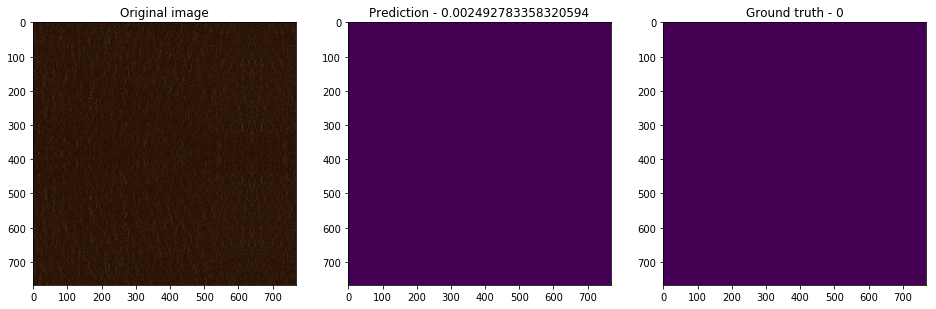

In [272]:
import matplotlib.pyplot as plt

for i in range(1):
    # read data
    batch = valid_gen.__next__()
    image = batch[0]
    gt_label = batch[1]['cls'].squeeze()
    gt_mask = batch[1]['seg'].squeeze()

    # predicting
    label, mask = model.predict(image)

    # visualizing
    plt.figure(figsize=(16, 6))

    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image.squeeze())

    plt.subplot(132)
    plt.title('Prediction - {}'.format(label.squeeze()))
    plt.imshow(mask.squeeze().round(3))

    plt.subplot(133)
    plt.title('Ground truth - {}'.format(gt_label.squeeze()))
    plt.imshow(gt_mask.squeeze())

    plt.show()